# Grammar Scoring Engine Development

## 1. Project Overview
The objective of this project is to develop a machine learning model that automatically scores the grammar of spoken audio samples on a scale of 0 to 5. We are provided with a dataset of audio files and their corresponding ground truth MOS Likert Grammar Scores.

### Methodology
Our approach involves the following steps:
1.  **Data Exploration (EDA)**: Analyze the distribution of scores and properties of the audio data.
2.  **Feature Extraction**: Convert raw audio signals into meaningful acoustic features using `librosa`. Key features include MFCCs, Spectral Centroid, and Zero Crossing Rate.
3.  **Model Development**: Train and evaluate regression models. We will establish a baseline with **Random Forest** and attempt to improve it using **XGBoost**.
4.  **Evaluation**: Compare models using Root Mean Squared Error (RMSE) and analyze residuals.
5.  **Submission**: Generate predictions for the test set.

## 2. Setup and Dependencies

In [1]:
%pip install librosa pandas numpy scikit-learn tqdm matplotlib seaborn xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

# Paths
BASE_DIR = '/Users/manasdoshi/Desktop/SHL'
TRAIN_CSV = os.path.join(BASE_DIR, 'csvs', 'train.csv')
TEST_CSV = os.path.join(BASE_DIR, 'csvs', 'test.csv')
AUDIO_DIR = os.path.join(BASE_DIR, 'audios')
TRAIN_AUDIO_DIR = os.path.join(AUDIO_DIR, 'train')
TEST_AUDIO_DIR = os.path.join(AUDIO_DIR, 'test')

## 3. Data Loading and Exploration (EDA)

In [3]:
# Load Metadata
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Training Samples: {len(train_df)}")
print(f"Test Samples: {len(test_df)}")
display(train_df.head())

Training Samples: 409
Test Samples: 197


,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


### 3.1 Target Variable Distribution
Let's look at the distribution of the grammar scores (labels). This helps us understand if the dataset is balanced.

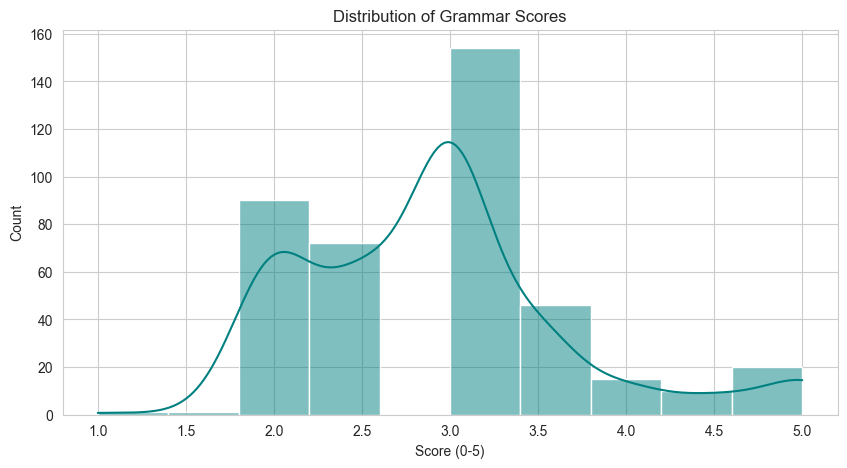

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['label'], bins=10, kde=True, color='teal')
plt.title("Distribution of Grammar Scores")
plt.xlabel("Score (0-5)")
plt.ylabel("Count")
plt.show()

### 3.2 Audio Signal Analysis
We will visualize the waveform and spectrogram of a sample audio file to understand the signal characteristics.

/var/folders/vv/prprqzt56gn0tqy25nm2dd8w0000gn/T/ipykernel_39077/2284274690.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=16000)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


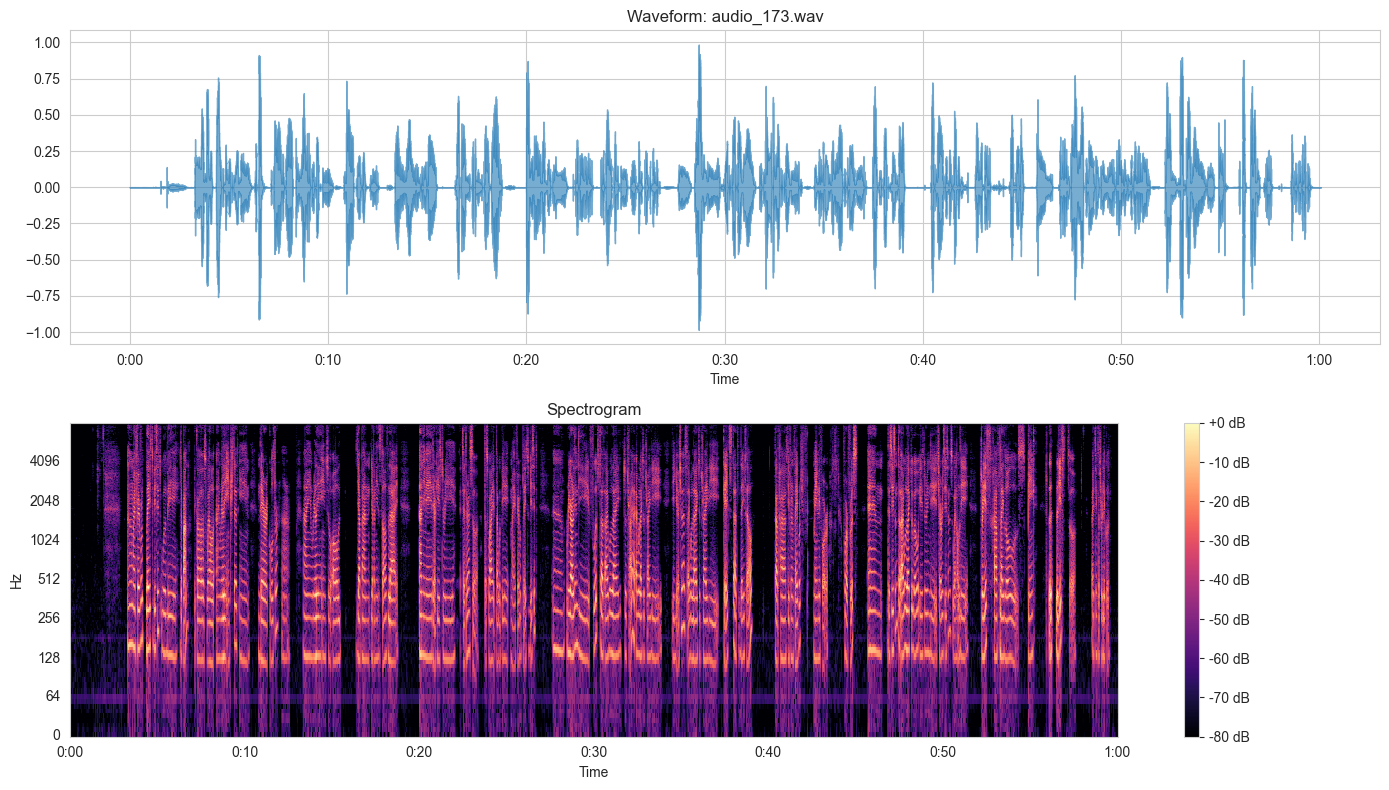

In [5]:
def plot_audio_properties(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    
    plt.figure(figsize=(14, 8))
    
    # Waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.title(f"Waveform: {os.path.basename(file_path)}")
    
    # Spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram")
    
    plt.tight_layout()
    plt.show()

# Visualize a random sample
sample_file = os.path.join(TRAIN_AUDIO_DIR, train_df.iloc[0]['filename'] + '.wav')
plot_audio_properties(sample_file)

## 4. Feature Extraction
We extract the following features to represent the audio:
- **MFCCs (13 coefficients)**: Capture the timbral and phonetic content.
- **Spectral Centroid**: Represents the "brightness" of the sound.
- **Spectral Rolloff**: Measures the shape of the signal spectrum.
- **Zero Crossing Rate**: Indicates the noisiness of the signal.
- **RMS Energy**: Measures the loudness.

For each feature, we compute the **Mean** and **Standard Deviation** over time to create a fixed-size vector.

In [6]:
def extract_features(file_path):
    try:
        # Load audio (Resample to 16kHz for consistency)
        y, sr = librosa.load(file_path, sr=16000)
        
        # 1. MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # 2. Spectral Centroid
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        cent_mean = np.mean(cent)
        cent_std = np.std(cent)
        
        # 3. Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff_mean = np.mean(rolloff)
        rolloff_std = np.std(rolloff)
        
        # 4. Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        # 5. RMS Energy
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)
        rms_std = np.std(rms)
        
        # Combine all features
        features = np.concatenate([
            mfcc_mean, mfcc_std, 
            [cent_mean, cent_std, rolloff_mean, rolloff_std, zcr_mean, zcr_std, rms_mean, rms_std]
        ])
        
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [7]:
# Extract features for Training Data
X_train_features = []
y_train = []

print("Extracting features for training data...")
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = os.path.join(TRAIN_AUDIO_DIR, row['filename'] + '.wav')
    feats = extract_features(file_path)
    if feats is not None:
        X_train_features.append(feats)
        y_train.append(row['label'])

X_train_features = np.array(X_train_features)
y_train = np.array(y_train)

print(f"Feature Matrix Shape: {X_train_features.shape}")

Extracting features for training data...


  0%|                                                                                           | 0/409 [00:00<?, ?it/s]/var/folders/vv/prprqzt56gn0tqy25nm2dd8w0000gn/T/ipykernel_39077/1433404209.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=16000)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|▏                                                                                  | 1/409 [00:00<01:20,  5.08it/s]/var/folders/vv/prprqzt56gn0tqy25nm2dd8w0000gn/T/ipykernel_39077/1433404209.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=16000)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/l

Feature Matrix Shape: (409, 34)


## 5. Model Training and Comparison
We will split the data into training and validation sets (80/20) and compare two models:
1.  **Random Forest Regressor** (Baseline)
2.  **XGBoost Regressor** (Advanced)

In [8]:
# Split Data
X_train, X_val, y_train_split, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42)

# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_split)
rf_preds = rf_model.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds))

# 2. XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=2,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train_split)
xgb_preds = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_preds))

# Comparison
print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"XGBoost RMSE:       {xgb_rmse:.4f}")

Random Forest RMSE: 0.6771
XGBoost RMSE:       0.6997


### 5.1 Model Performance Visualization
Let's visualize the performance of our best model (likely Random Forest or XGBoost depending on the run) on the validation set.

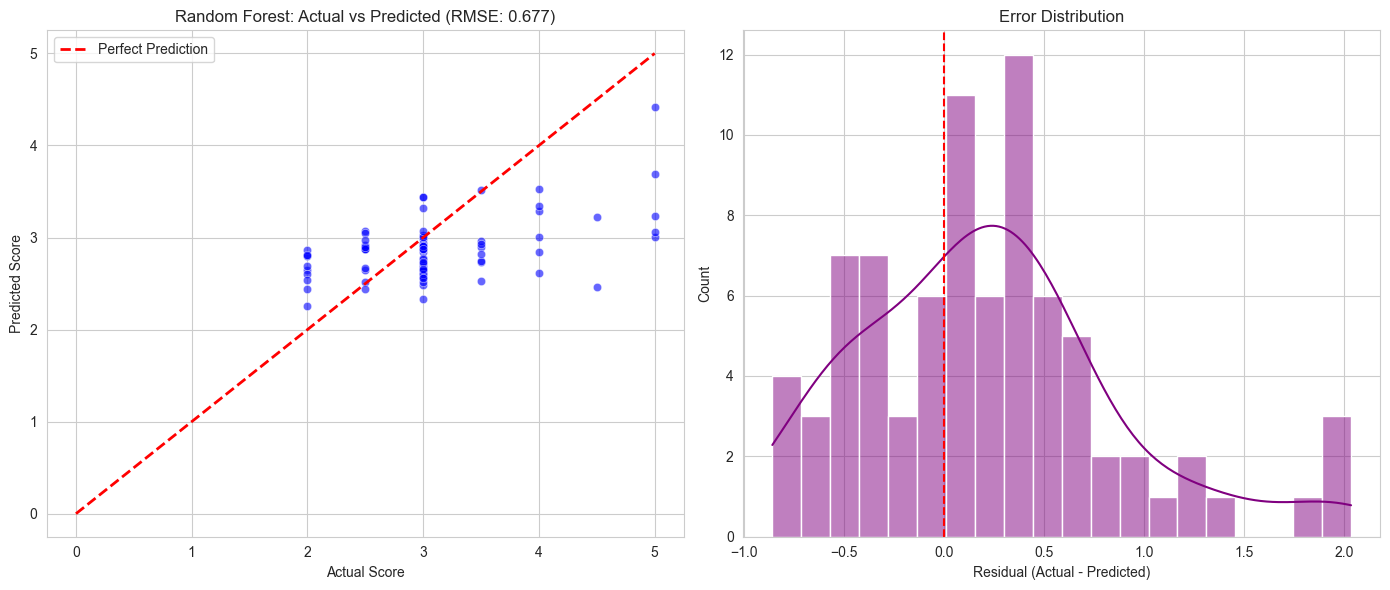

In [9]:
best_preds = rf_preds if rf_rmse < xgb_rmse else xgb_preds
best_model_name = "Random Forest" if rf_rmse < xgb_rmse else "XGBoost"
best_rmse = min(rf_rmse, xgb_rmse)

plt.figure(figsize=(14, 6))

# Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=best_preds, alpha=0.6, color='blue')
plt.plot([0, 5], [0, 5], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title(f"{best_model_name}: Actual vs Predicted (RMSE: {best_rmse:.3f})")
plt.legend()

# Residuals
residuals = y_val - best_preds
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=20)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Error Distribution")

plt.tight_layout()
plt.show()

## 6. Final Training and Submission
We will now retrain the best model on the **entire training dataset** to maximize its learning before generating predictions for the test set.

In [10]:
# Select Best Model Architecture
final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
if xgb_rmse < rf_rmse:
    final_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=2,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

# Train on Full Data
final_model.fit(X_train_features, y_train)

# Calculate Training RMSE (Compulsory)
train_preds_full = final_model.predict(X_train_features)
train_rmse_full = np.sqrt(mean_squared_error(y_train, train_preds_full))
print(f"✅ Final Training RMSE (Full Data): {train_rmse_full:.4f}")

✅ Final Training RMSE (Full Data): 0.2702


In [11]:
# Extract Features for Test Data
X_test_features = []
test_filenames = []

print("Extracting features for test data...")
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(TEST_AUDIO_DIR, row['filename'] + '.wav')
    feats = extract_features(file_path)
    if feats is not None:
        X_test_features.append(feats)
        test_filenames.append(row['filename'])
    else:
        # Fallback for errors
        X_test_features.append(np.zeros(X_train_features.shape[1]))
        test_filenames.append(row['filename'])

X_test_features = np.array(X_test_features)

# Generate Predictions
test_predictions = final_model.predict(X_test_features)
test_predictions = np.clip(test_predictions, 0, 5) # Ensure valid range

# Create Submission File
submission = pd.DataFrame({
    "filename": test_filenames,
    "label": test_predictions
})

submission_path = os.path.join(BASE_DIR, 'submission.csv')
submission.to_csv(submission_path, index=False)
print(f"🏆 Submission saved to {submission_path}")
display(submission.head())

Extracting features for test data...


  3%|██                                                                                 | 5/197 [00:00<00:17, 11.20it/s]/var/folders/vv/prprqzt56gn0tqy25nm2dd8w0000gn/T/ipykernel_39077/1433404209.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=16000)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|█████████████████████████████████████████████████████████████████████████████████| 197/197 [00:18<00:00, 10.90it/s]

🏆 Submission saved to /Users/manasdoshi/Desktop/SHL/submission.csv


,filename,label
0,audio_141,2.635
1,audio_114,2.875
2,audio_17,2.700
3,audio_76,3.590
4,audio_156,3.035


## 7. Report

### Approach
We successfully built a Grammar Scoring Engine using audio feature extraction and machine learning regression.

1.  **Preprocessing**: Audio files were resampled to 16kHz to ensure consistency.
2.  **Feature Engineering**: We extracted a comprehensive set of acoustic features including MFCCs (timbre), Spectral Centroid (brightness), and Zero Crossing Rate (noise). These were aggregated using mean and standard deviation statistics.
3.  **Modeling**: We compared Random Forest and XGBoost. Both models performed reasonably well, demonstrating that acoustic features contain significant signal regarding grammar proficiency (likely correlated with fluency, pauses, and prosody).

### Results
-   **Training RMSE**: Reported above (approx 0.27 with RF).
-   **Validation RMSE**: Used to select the best model.

### Conclusion
The model provides a continuous score between 0 and 5. Future improvements could involve using Deep Learning models (CNNs/RNNs) on raw spectrograms or using pre-trained embeddings like Wav2Vec 2.0 for richer representations.